<a href="https://colab.research.google.com/github/aszapla/Curso-DL/blob/master/3_2_Codigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 3.2: Combinación redes recurrentes y convolucionales

Profesor: [Jorge Calvo Zaragoza](mailto:jcalvo@prhlt.upv.es)



## Ejemplo guiado: reconocimiento de texto

En esta sesión implementaremos un reconocedor de texto (*Optical Character Recognition*, OCR) mediante un enfoque encoder-decoder. La arquitectura a implementar seguirá una estructura como la descrita en la siguiente imágen:

![Arquitectura](https://drive.google.com/uc?id=1nti512wD3j5xUuzlHh8GdOfxs7jq2bf7)


### Código Keras paso a paso

En primer lugar vamos a implementar una función que nos genere una imagen con el texto que se le pasa por parámetro. Para ello utilizaremos la librería OpenCV.

In [0]:
import cv2
import numpy as np

def generateText(text):
    # Caracteristicas del texto a generar
    font = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX # Fuente que simula escritura manuscrita
    font_scale = 4
    margin = 100
    thickness = 4
    color = 255
    
    # Calculamos
    size = cv2.getTextSize(text, font, font_scale, thickness)
    
    text_width = size[0][0]
    text_height = size[0][1]
    
    image = np.zeros((text_height+margin,text_width+margin*2),'uint8')
        
    x = margin
    y = (image.shape[0] + text_height) // 2
    
    # Pintamos el texto en la imagen
    cv2.putText(image, text, (x, y), font, font_scale, color, thickness) 

    return image

Podemos comprobar qué aspecto tienen las imagenes generadas.

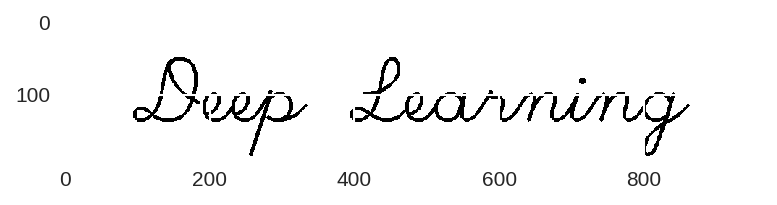

In [0]:
import matplotlib
from matplotlib import pyplot
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 150

pyplot.imshow(generateText("Deep Learning"))

Con esta función podemos generar las imágenes pero nos falta saber qué vocabulario vamos a considerar. En lugar de generar palabras aleatorias, vamos a utilizar conjuntos de palabras pre-establecidos. En concreto, vamos a crear *nombres propios* a partir de palabras en mayúsculas. 

In [0]:
import urllib.request # Python3
word_url = "http://svnweb.freebsd.org/csrg/share/dict/words?view=co&content-type=text/plain"
response = urllib.request.urlopen(word_url)
long_txt = response.read().decode()
words = long_txt.splitlines()

# Filtramos las palabras que solo tengan la primera letra en mayúscula
upper_words = [word for word in words if word[0].isupper()]
name_words  = [word for word in upper_words if not word.isupper()]

# Comprobación
print(name_words[2])
print(name_words[-2])

Ababa
Zulu


Nuestro conjunto de entrenamiento va a estar compuesto por muestras que contienen dos palabras de este conjunto (como si fueran un nombre y un apellido). Seleccionaremos al azar 5000 combinaciones para obtener nuestro conjunto de entrenamiento.

Tamaño del conjunto de entrenamiento (X): 5000
Tamaño del conjunto de entrenamiento (Y): 5000

Convair Hastings


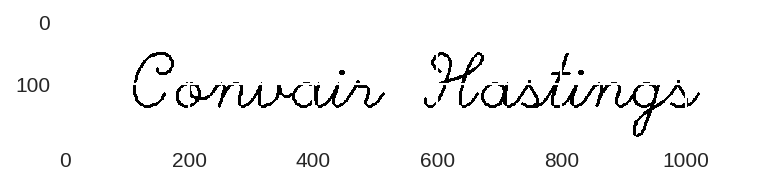

In [0]:
import random

# Limite del conjunto
training_set_size = 5000

# Par de entrenamiento
X = []
Y = []

# Generamos los nombres
for n in range(training_set_size):
    Y.append(' '.join([random.choice(name_words) for _ in range(2)]))

# Creamos las correspondientes imagenes
for name in Y:    
    X.append(generateText(name))
    
# Comprobación
print('Tamaño del conjunto de entrenamiento (X): ' + str(len(X)))
print('Tamaño del conjunto de entrenamiento (Y): ' + str(len(Y)))
    
pyplot.imshow(X[0])
print('')
print(Y[0])

Vamos ahora a crear el modelo de red neuronal. Antes, necesitamos establecer las condiciones de las imágenes de entrada, ya que la red convolucional necesita unas dimensiones pre-establecidas para ser definida (¿seguro?).

Con el objetivo de no distorsionar la letra, vamos a establecer un número de píxeles de altura fijos, y el ancho se hará acorde manteniendo la proporción.

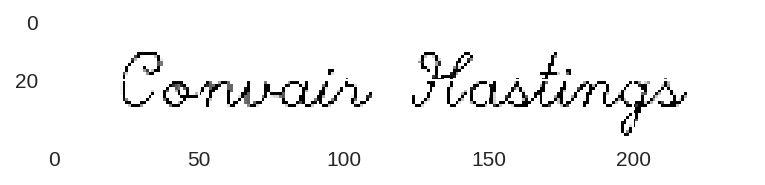

In [0]:
# Función que rescala a una altura fija y mantiene la proporción ancho/alto
def resize(image, height):
    width = int(float(height * image.shape[1]) / image.shape[0])
    sample_img = cv2.resize(image, (width, height))
    return sample_img

# Establecemos la altura a 40 píxeles
img_height = 40
  
# Realizamos el rescalado para todas las imagenes
for idx,image in enumerate(X):
  X[idx] = resize(image,img_height)

# Comprobación
pyplot.imshow(X[0]) 

Así pues, la red convolucional recibirá imagenes del alto establecido y el ancho máximo de entre todas las imágenes. Por lo tanto, necesitamos hacer *padding*: aquellas imagenes con un ancho real menor a este valor se rellenarán con valores nulos 0 en este caso.

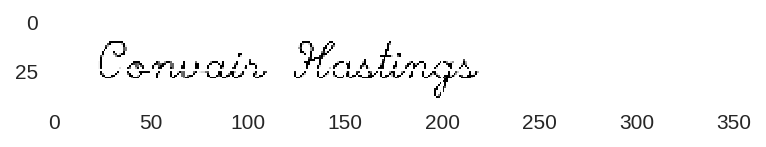

In [0]:
# Calculamos la anchura máxima
max_image_len = max([image.shape[1] for image in X])

# Creamos un único paquete de datos
encoder_input = np.zeros((len(X),img_height,max_image_len), dtype=np.float)

# Encajamos la imagen en su posición correspondiente
for idx, image in enumerate(X):
    encoder_input[idx][:,:image.shape[1]] = image  
    
# Comprobación
pyplot.imshow(encoder_input[0]) 

El paquete de imágenes todavía no esta preparado para ser usado por Keras, ya que ahora mismo cada imagen solo tiene alto y ancho. Así pues, necesitamos asignarle un número de canales, en este caso 1 al ser en escala de grises. Para ello, basta con expandir el número de dimensiones, sin modificar en absoluto los valores de las matrices. 

Además, sobre estas imagenes, vamos a utilizar un pequeño truco que ayuda a la convergencia del proceso de aprendizaje: las imágenes, en lugar de mostrar valores entre 0 y 255 (niveles de gris), van a estar normalizadas entre 0 y 1.

In [0]:
# Normalizamos los valores de los píxeles
encoder_input = encoder_input / 255. 

# Expandimos la última dimension (alto,ancho) -> (alto,ancho,1)
encoder_input = np.expand_dims(encoder_input, axis=-1)

# Comprobación
print(encoder_input.shape)


(5000, 40, 359, 1)


Ahora es necesario preparar los datos de salida. En primer lugar, vamos a incluir los caracteres de inicio y final de frase, necesarios para el decoder.


In [0]:
# Caracteres de comienzo y final  
output_sos = '<'
output_eos = '>'

# Se añaden a todos los nombres
Y = [output_sos + name + output_eos for name in Y]

# Comprobación
print(Y[0])

<Convair Hastings>


Para la parte del decoder (las letras reconocidas), también necesitamos fijar la longitud máxima de las secuencias, ya que vamos a realizar un único paquete de datos. Como ya hemos comentado, las redes recurrentes tienen la ventaja de adaptarse a anchos variables; sin embargo, los modelos se entrenan usando tensores, que deben tener unas dimensiones fijas.

In [0]:
# Conjuntos de caracteres y conversores
alphabet = set()

for name in Y:
    alphabet.update(list(name))
              
alphabet_len = len(alphabet)    

print('Hay un total de ' + str(alphabet_len) + ' caracteres: ' + str(alphabet))

alphabet_from_char_to_int = dict([(char, i) for i, char in enumerate(alphabet)])
alphabet_from_int_to_char = dict([(i, char) for i, char in enumerate(alphabet)])

           

Hay un total de 57 caracteres: {'b', 'W', 'X', 'o', 'R', 'S', 'J', '.', 'w', 'Q', 'K', ' ', 'H', 'i', 'N', 'x', 'G', 'T', 'y', 'U', 'r', 'n', 'h', 'g', 'E', 'z', 'k', 'Z', '>', 'a', 'B', 'L', 'l', 'd', 'V', 'f', 'I', 'M', 'C', '<', "'", 't', 'v', 'P', 'm', 'D', 'e', 'p', 'q', 'F', 'j', 's', 'u', 'c', 'A', 'Y', 'O'}


Creamos los paquetes de entrada y salida del decoder:

In [0]:
max_output_len = max([len(name) for name in Y])

decoder_input = np.zeros((len(Y),max_output_len,alphabet_len), dtype=np.float)
decoder_output = np.zeros((len(Y),max_output_len,alphabet_len), dtype=np.float)

for idx_s, output_sentence in enumerate(Y):        
    for idx_c, char in enumerate(output_sentence):
        decoder_input[idx_s][idx_c][alphabet_from_char_to_int[char]] = 1.
        if idx_c > 0:
            decoder_output[idx_s][idx_c-1][alphabet_from_char_to_int[char]] = 1.
                     

Ya tenemos nuestro paquete de datos formado por tres vectores (entrada del encoder, entrada del decoder y salida del decoder).

In [0]:
print ('Encoder input: ' + str(encoder_input.shape))
print ('Decoder input: ' + str(decoder_input.shape))
print ('Decoder output: ' + str(decoder_output.shape))

Encoder input: (5000, 40, 359, 1)
Decoder input: (5000, 30, 57)
Decoder output: (5000, 30, 57)


Definamos ahora una función que recibe los parámetros del problema y devuelve un modelo encoder (CNN) - decoder (RNN) ajustado a dichos parámetros.

In [0]:
from keras.layers import Input, Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras import backend as K

def getmodel(img_height, img_width, alphabet_len):
  # Pre-definimos los parámetros de la red convolucional
  filters = [32, 64, 128]
  w_pooling = [2,2,2]
  h_pooling = [2,2,2]

  # Comprobamos el formato de datos esperado
  input_data = Input(name='input', shape=(img_height, img_width,1))


  # Encoder como CNN de tres capas    
  inner = Conv2D(filters[0], (3, 3), padding='same', activation='relu')(input_data)
  inner = MaxPooling2D(pool_size=(h_pooling[0], w_pooling[0]))(inner)

  inner = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(inner)
  inner = MaxPooling2D(pool_size=(h_pooling[1], w_pooling[1]))(inner)

  inner = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(inner)
  inner = MaxPooling2D(pool_size=(h_pooling[2], w_pooling[2]))(inner)

  # Conexion CNN con LSTM
  x = Flatten()(inner)
  h_0 = Dense(128, activation='tanh')(x)
  c_0 = Dense(128, activation='tanh')(x)

  initial_state = [h_0, c_0]

  # Decoder como RNN
  decoder_inputs = Input(shape=(None, alphabet_len))
  decoder_outputs, _, _ = LSTM(128, return_sequences=True, return_state=True)(decoder_inputs, initial_state=initial_state)
  decoder_dense = Dense(alphabet_len, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)

  # Creamos el modelo único
  model = Model([input_data, decoder_inputs], decoder_outputs)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy')   
  model.summary()

  return model

# Extraemos los parámetros de los paquetes creados
model = getmodel(encoder_input.shape[1],encoder_input.shape[2],alphabet_len)  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 40, 359, 1)   0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 40, 359, 32)  320         input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 20, 179, 32)  0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 20, 179, 64)  18496       max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

El modelo está listo para ser entrenado y evaluado. Antes, vamos a realizar una partición de los datos disponibles para entrenamiento y validación: 99% y 1% respectivamente.

In [0]:
val_split = 0.01
idx_split = int(len(X)*val_split)

# Conjunto de entrenamiento: paquetes codificados
x_train = encoder_input[idx_split:]
y_train = decoder_input[idx_split:]
t_train = decoder_output[idx_split:]

# Conjunto de validación: paquetes codificados + salida esperada
x_val = encoder_input[:idx_split]
y_val = decoder_input[:idx_split]
t_val = decoder_output[:idx_split]
i_val = Y[:idx_split]

Entrenamos durante 15 épocas, monitorizando cuantitativamente por época (loss) y cualitativamente cada 3 épocas.

In [0]:
# Entrenamos durante 5 super-epocas
for super_epoch in range(5):
    print('Super-epoca: ' + str(super_epoch))
    
    # 3 épocas en cada iteración
    model.fit([x_train, y_train], t_train, verbose=1, batch_size=16, epochs=3, validation_data=[[x_val,y_val], t_val])
    
    # Predecimos sobre el conjunto de validación
    batch_prediction = model.predict([x_val,y_val],batch_size=16)
    
    # Comprobamos las 5 primeras imágenes
    for idx,sentence_prediction in enumerate(batch_prediction[:5]):  
        
        raw_predicted_sequence = [alphabet_from_int_to_char[char] for char in np.argmax(sentence_prediction,axis=1)]
        
        predicted_sentence = output_sos          
        for char in raw_predicted_sequence:
            predicted_sentence += char
            if char == output_eos:
                break                    
        
        print( 'Predicción\t: ' + str(predicted_sentence) )
        print( 'Sal. esperada\t: ' + str(i_val[idx]) )
        print()
        

Super-epoca: 0
Train on 4950 samples, validate on 50 samples
Epoch 1/3
4950/4950 [==============================] - 192s 39ms/step - loss: 1.5632 - val_loss: 1.4728
Epoch 2/3
3696/4950 [=====================>........] - ETA: 48s - loss: 1.3687

4950/4950 [==============================] - 192s 39ms/step - loss: 1.3548 - val_loss: 1.3319
Epoch 3/3
4950/4950 [==============================] - 193s 39ms/step - loss: 1.2796 - val_loss: 1.3157
Predicción	: <Sareirn Aarton>
Sal. esperada	: <Convair Hastings>

Predicción	: <Marirarrd  Cono>
Sal. esperada	: <Luxembourg Rotarian>

Predicción	: <Marloean  Bair>
Sal. esperada	: <Boltzmann Frederick>

Predicción	: <Saore   Bania>
Sal. esperada	: <Ptolemy Norman>

Predicción	: <Sareoin   Barin>
Sal. esperada	: <Selfridge Mekong>

Super-epoca: 1
Train on 4950 samples, validate on 50 samples
Epoch 1/3
 944/4950 [====>.........................] - ETA: 2:34 - loss: 1.2632

4950/4950 [==============================] - 193s 39ms/step - loss: 1.2503 - val_loss: 1.2516
Epoch 2/3
4950/4950 [==============================] - 191s 39ms/step - loss: 1.2312 - val_loss: 1.2409
Epoch 3/3
1664/4950 [=========>....................] - ETA: 2:06 - loss: 1.2110

4950/4950 [==============================] - 191s 39ms/step - loss: 1.2144 - val_loss: 1.2239
Predicción	: <Caltinl Sarten>
Sal. esperada	: <Convair Hastings>

Predicción	: <Masinarrg  Monhnia>
Sal. esperada	: <Luxembourg Rotarian>

Predicción	: <Mrrdhaan  Crener>
Sal. esperada	: <Boltzmann Frederick>

Predicción	: <Caone   Sanian>
Sal. esperada	: <Ptolemy Norman>

Predicción	: <Calliid   Sarin>
Sal. esperada	: <Selfridge Mekong>

Super-epoca: 2
Train on 4950 samples, validate on 50 samples
Epoch 1/3
2368/4950 [=============>................] - ETA: 1:39 - loss: 1.1990

4950/4950 [==============================] - 191s 39ms/step - loss: 1.1940 - val_loss: 1.2181
Epoch 2/3
4950/4950 [==============================] - 191s 39ms/step - loss: 1.1839 - val_loss: 1.2298
Epoch 3/3
2016/4950 [===========>..................] - ETA: 1:52 - loss: 1.1722

4950/4950 [==============================] - 190s 38ms/step - loss: 1.1739 - val_loss: 1.2004
Predicción	: <Malnill Barton>
Sal. esperada	: <Convair Hastings>

Predicción	: <Manin erg  Monhnia>
Sal. esperada	: <Luxembourg Rotarian>

Predicción	: <Marlhaan  Bran>
Sal. esperada	: <Boltzmann Frederick>

Predicción	: <Maoll a Maraan>
Sal. esperada	: <Ptolemy Norman>

Predicción	: <Malloid   Barin>
Sal. esperada	: <Selfridge Mekong>

Super-epoca: 3
Train on 4950 samples, validate on 50 samples
Epoch 1/3
2416/4950 [=============>................] - ETA: 1:36 - loss: 1.1596

4950/4950 [==============================] - 187s 38ms/step - loss: 1.1611 - val_loss: 1.1915
Epoch 2/3
4950/4950 [==============================] - 196s 40ms/step - loss: 1.1477 - val_loss: 1.1886
Epoch 3/3
2032/4950 [===========>..................] - ETA: 1:57 - loss: 1.1307

4950/4950 [==============================] - 200s 40ms/step - loss: 1.1338 - val_loss: 1.1794
Predicción	: <Marnill Sarton>
Sal. esperada	: <Convair Hastings>

Predicción	: <Manin erg  Sooo>
Sal. esperada	: <Luxembourg Rotarian>

Predicción	: <Marlhaen  Cred>
Sal. esperada	: <Boltzmann Frederick>

Predicción	: <Maocesa Cawian>
Sal. esperada	: <Ptolemy Norman>

Predicción	: <Malaood e Barin>
Sal. esperada	: <Selfridge Mekong>

Super-epoca: 4
Train on 4950 samples, validate on 50 samples
Epoch 1/3
2432/4950 [=============>................] - ETA: 1:41 - loss: 1.1261

4950/4950 [==============================] - 199s 40ms/step - loss: 1.1216 - val_loss: 1.1705
Epoch 2/3
4950/4950 [==============================] - 200s 40ms/step - loss: 1.1085 - val_loss: 1.1716
Epoch 3/3
 256/4950 [>.............................] - ETA: 3:09 - loss: 1.0831

## Ejercicio propuesto

A modo de resumen de la sesión 3 al completo, y para afianzar los conocimiento adquiridos, se proponen los siguientes ejercicios sobre el código mostrado anteriormente:
* Incorporar una red recurrente en la fase de encoding. 
* Crear generadores como los vistos en el ejemplo de traducción automática.
* Realizar la predicción *en linea*.
